In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from random import random

In [2]:
np.array(1)

array(1)

In [3]:
import os

In [4]:
from lcmcmc.utils import get_data_dir_path

In [5]:
from kndetect.utils import load_pcs

# Load data

In [6]:
pcs = load_pcs()

In [7]:
new_object_df = pd.read_csv(os.path.join(get_data_dir_path(), "perfect_sims.csv"))

The perfect simulations are simulated for LSST so they have 6 differnet bands. Since right now we run the tests on the ZTF data which has only the g and r bands, we will use only these 2 from LSST for compution

In [8]:
mu = np.load(os.path.join(get_data_dir_path(), "mu.npy"))
scale = np.load(os.path.join(get_data_dir_path(), "scale.npy"))

# RUN MCMC

In [9]:
from lcmcmc.model import jd_model_pcs
import jax.numpy as jnp
import jax
import tensorflow_probability.substrates.jax as tfp

2023-08-07 16:29:06.771772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
rng = jax.random.PRNGKey(7)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
new_object_df=new_object_df[new_object_df["object_index"]<10]

In [12]:
index = np.zeros((len(new_object_df), 2), dtype=np.int32)

index[:, 0] = np.asarray(new_object_df["object_index"].values)
index[:, 1] = np.asarray(new_object_df["band_index"].values)

x_range = jnp.asarray(new_object_df["time"])

observed_value = np.array(new_object_df["flux"].values, dtype=jnp.float32)
observed_sigma = np.array(new_object_df["fluxerr"].values, dtype=jnp.float32)

jd = jd_model_pcs(index, x_range, pcs, mu, scale)

In [13]:
len(observed_sigma)

100

In [14]:
index = jnp.array(index)

In [15]:
index[:,0]

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)

In [16]:
# Run the mcmc
run_mcmc = lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
        100, 
        jd, 
        n_chains=10, 
        num_adaptation_steps=100, 
        seed=seed,
        sigma=observed_sigma, 
        obs=observed_value,
    )


sample_rng, rng  = jax.random.split(rng)
mcmc_samples, sampler_stats = run_mcmc(sample_rng)

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/lcmcmc/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/lcmcmc/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:284: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)
/pbs/thr

In [17]:
from lcmcmc.parametric_fits import parametric_fn_pcs
import matplotlib.pyplot as plt

In [18]:
mcmc_samples.coeffs.shape

(100, 10, 10, 6)

(array([1.340e+02, 6.110e+02, 2.440e+02, 1.100e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.100e+01,
        1.080e+02, 2.580e+02, 3.500e+02, 2.200e+02, 4.600e+01, 7.000e+00,
        5.000e+00, 2.900e+01, 7.700e+01, 1.350e+02, 2.040e+02, 2.250e+02,
        1.860e+02, 8.000e+01, 4.300e+01, 1.100e+01, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.010e+02, 7.310e+02, 6.700e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 7.400e+01, 3.690e+02, 4.860e+02,
        3.060e+02, 9.440e+02, 6.730e+02, 1.220e+02, 2.000e+01, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

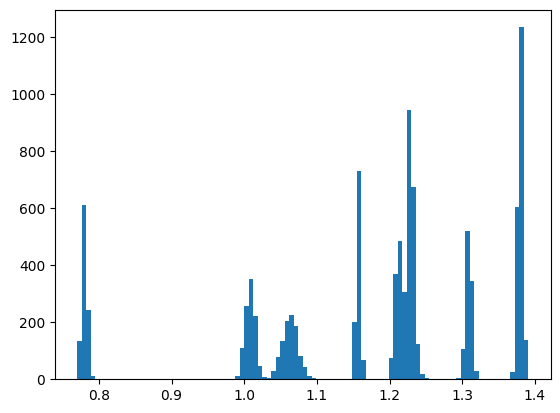

In [19]:
plt.hist(mcmc_samples.coeffs[:, :, :, 0].flatten(), bins=100)

0


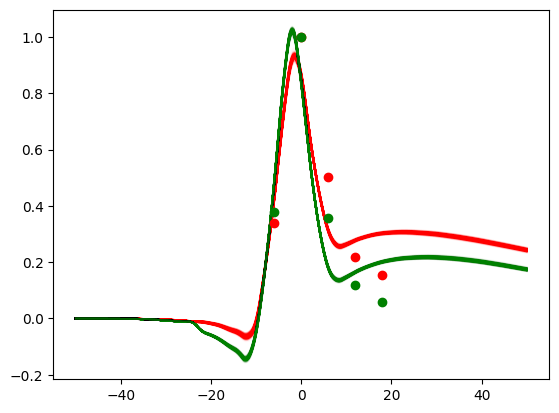

1


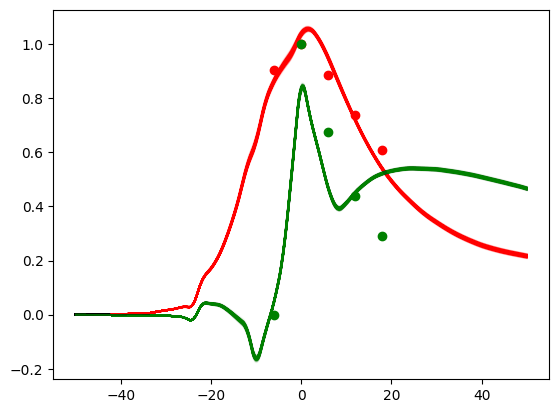

2


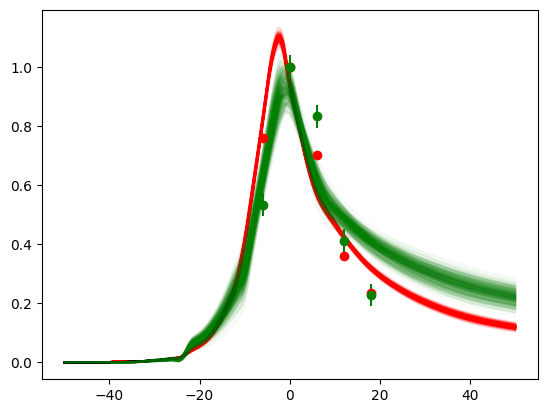

3


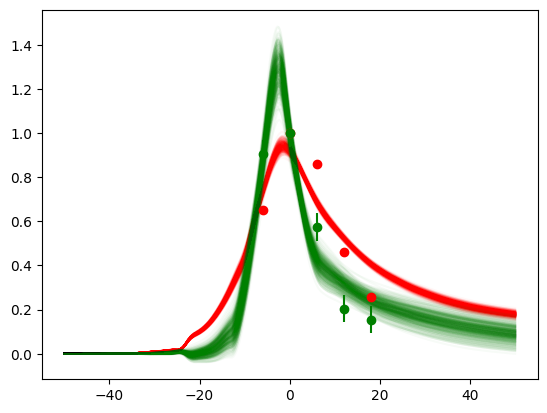

4


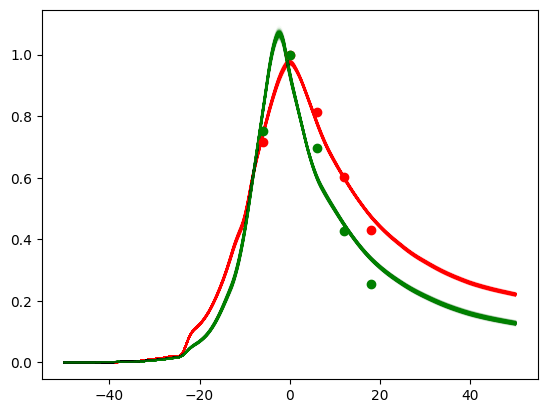

5


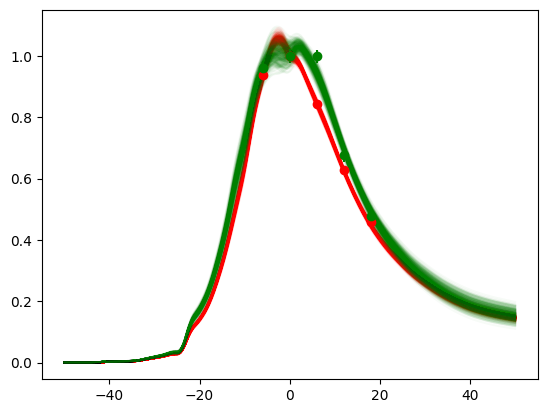

6


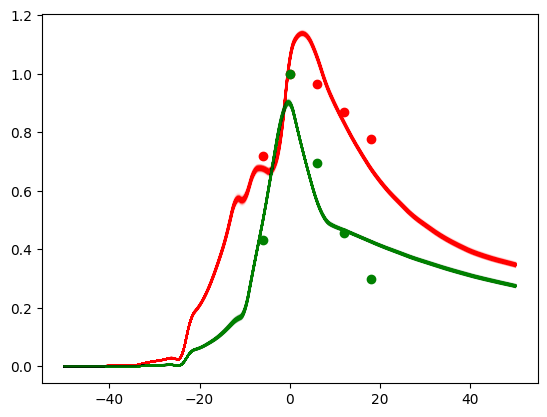

7


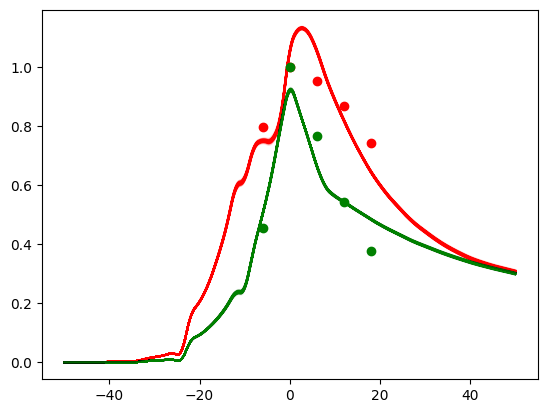

8


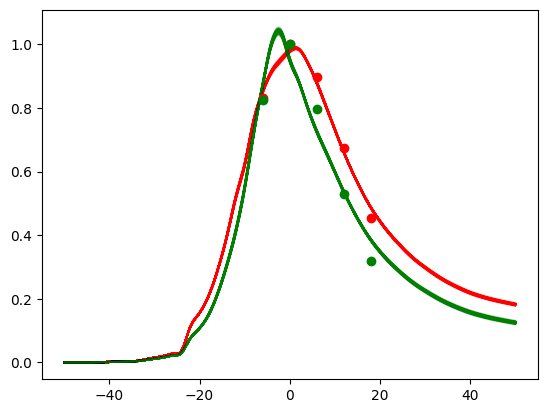

9


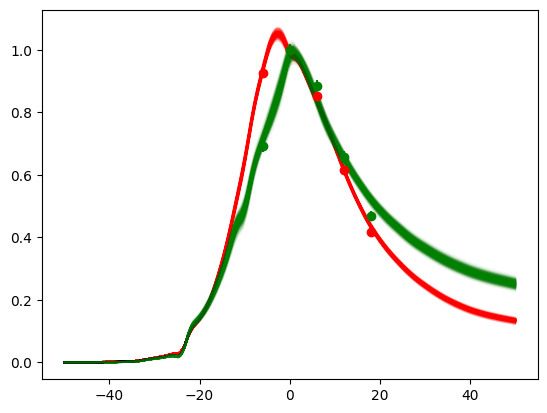

In [20]:
colors = ['r', 'g']
for event_num in range(len(index)):
    print(event_num)
    plt.figure()
    object_df = new_object_df[new_object_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):
            for chain_num in range(4):
                c1 = mcmc_samples.coeffs[sample_no, chain_num, event_num, 0 + band*3]
                c2 = mcmc_samples.coeffs[sample_no, chain_num, event_num, 1 + band*3]
                c3 = mcmc_samples.coeffs[sample_no, chain_num, event_num, 2 + band*3]
                
                predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
                #print( predictions)
                plt.plot(np.arange(-50, 50.25, .25), predictions, alpha=.03, color=colors[band])


        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])
    if event_num==9:
        break
    plt.show()